In [107]:
from matplotlib import pyplot as plt
import numpy as np
from fpl import FPL
import aiohttp
import asyncio
import pandas as pd
from random import shuffle
print("hello FPL")

hello FPL


### Get 50 players with highest value per dollar and see what happens

In [102]:
async def get_value_data():
    data = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    position_map = {
        1: "Goalkeeper",
        2: "Defender",
        3: "Midfielder",
        4: "Forward"
    }
    async with aiohttp.ClientSession() as session:
        fpl = FPL(session)
        for i in range(1, 498):
            try :
                player = await fpl.get_player(i)
                value = float(player.points_per_game) / float(player.now_cost)
                name = player.first_name + " " + player.second_name
                data.loc[i] = [name, position_map[player.element_type], float(player.points_per_game), float(player.minutes), float(player.now_cost), float(value)]
            except ValueError:
                print(f"player not found {i}")
    data.sort_values(by = ['value'], inplace = True, ascending = False)
    return data
    
    
value_data = await get_value_data()
value_data.head()

,Name,position,points_per_game,minutes,now_cost,value
240,Luke Thomas,Defender,5.0,267.0,45.0,0.111111
429,David Martin,Goalkeeper,4.0,435.0,40.0,0.100000
104,Marcos Alonso,Defender,5.6,1429.0,60.0,0.093333
327,Florian Lejeune,Defender,4.0,440.0,45.0,0.088889
10,Pablo Marí,Defender,4.0,113.0,45.0,0.088889


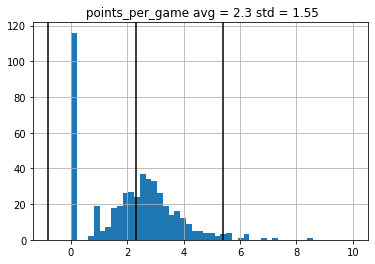

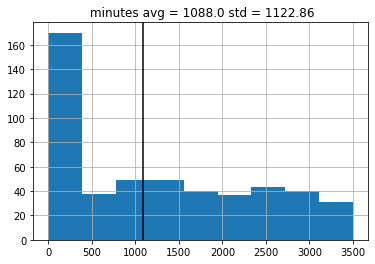

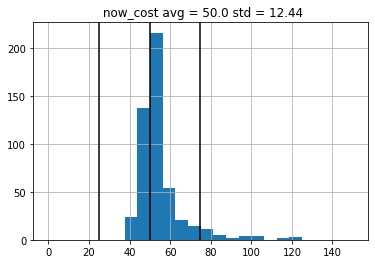

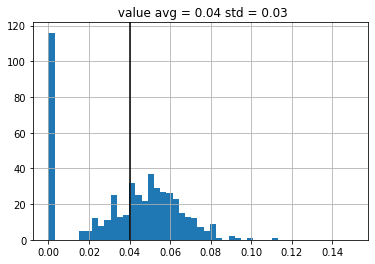

(0.04, 0.03)

In [103]:
def visualize_distribution(data, column, bins, normal  = True):
    median = round(data[column].median(), 2)
    std = round(data[column].std(), 2)
    data[column].hist(bins = bins)
    plt.axvline(median, color = 'black')
    if normal:
        plt.axvline(median - 2 * std, color = 'black')
        plt.axvline(median + 2 * std, color = 'black')
    plt.title(f" {column} avg = {median} std = {std}")
    plt.show()
    return median, std

visualize_distribution(value_data, 'points_per_game', bins = np.linspace(0, 10, 50))
visualize_distribution(value_data, 'minutes', bins = np.linspace(0, 3500, 10), normal = False)
visualize_distribution(value_data, 'now_cost', bins = np.linspace(0, 150, 25))
visualize_distribution(value_data, 'value', bins = np.linspace(0, 0.15, 50), normal = False)

In [156]:
def greedy_random_with_superstar(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length, num_superstars = 3, superstar_search_width = 15, superstar_minute_threshold = 2000):
    superstar_data = data[data['minutes'] > superstar_minute_threshold]
    superstar_data.sort_values(by='points_per_game', ascending = False, inplace=True)
    superstar_data = superstar_data.head(superstar_search_width)
    superstars = superstar_data.sample(num_superstars)

    value_players_data = data[~(data["Name"].isin(superstars["Name"]))]
    for _, superstar in superstars.iterrows():
        if superstar.position == "Forward": num_forwards -= 1
        elif superstar.position == "Midfielder": num_midfielders -= 1
        elif superstar.position == "GoalKeeper": num_goalkeepers -= 1
        budget -= superstar.now_cost
        squad_length -= 1

    value_players = greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)
    players_selected = pd.concat((superstars, value_players))
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
    

def greedy_random(data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length):
    expected_points = 0
    players_selected = pd.DataFrame(columns=['Name', 'position', 'points_per_game', 'minutes', 'now_cost', 'value'])
    choices = ["Forward"] * num_forwards + ["Midfielder"] * num_midfielders + ["Defender"] * num_defenders + ["Goalkeeper"] * num_goalkeepers
    total_cost = 0
    shuffle(choices)
    for i in range(squad_length):
        choice = choices.pop()
        choice_data = data[(data['position'] == choice) & (data['now_cost'] + total_cost < budget)]
        if not choice_data.shape[0]:
            print("Budget error")
        choice_data.sort_values(by=['value'], inplace = True, ascending = False)
        player_selected = choice_data.iloc[0]
        players_selected.loc[i] = player_selected
        total_cost += player_selected["now_cost"]
        data = data[data["Name"] != player_selected["Name"]]
        
    players_selected.sort_values(by=['position'], inplace = True)
    return players_selected
        

def get_valuable_players(value_data, minute_threshold = 1000, num_forwards = 3, num_midfielders = 5, num_defenders = 5, num_goalkeepers = 2, budget = 1000, squad_length = 15):
    value_data = value_data[value_data["minutes"] > minute_threshold]
    return greedy_random_with_superstar(value_data, num_forwards, num_midfielders, num_defenders, num_goalkeepers, budget, squad_length)

get_valuable_players(value_data)

,Name,position,points_per_game,minutes,now_cost,value
0,Marcos Alonso,Defender,5.6,1429.0,60.0,0.093333
2,Phil Bardsley,Defender,3.7,1890.0,45.0,0.082222
5,Willy Boly,Defender,4.4,1980.0,55.0,0.080000
6,Charlie Taylor,Defender,3.5,1944.0,45.0,0.077778
11,Ciaran Clark,Defender,3.5,1186.0,45.0,0.077778
366,Danny Ings,Forward,5.2,2800.0,85.0,0.061176
303,Anthony Martial,Forward,6.2,2625.0,90.0,0.068889
4,Michail Antonio,Forward,4.6,1767.0,65.0,0.070769
1,Hugo Lloris,Goalkeeper,4.7,1808.0,55.0,0.085455
7,Alex McCarthy,Goalkeeper,3.7,2520.0,45.0,0.082222
